# Figure S4: Non-independent cost of infection

Import packages.

In [1]:
import sys
sys.path.append('../lib/')
from cycler import cycler
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import palettable
import plotting
import projgrad
import scipy.optimize
import evolimmune
import analysis
%load_ext autoreload
%autoreload 2
plt.style.use(['paper'])
plt.rc('axes', prop_cycle=cycler('color', palettable.colorbrewer.qualitative.Dark2_4.mpl_colors))
black = matplotlib.rcParams['text.color']
eps = 1e-8

use czrecursion, cztogrowthrate
use cstepmarkov


Define growth rates.

In [2]:
def Lambda(p00, p01, p10, p11, pienv1, pienv2, lambda_, mu1, mu2, nu):
    return pienv1*pienv2*np.log(np.exp(-2*lambda_-nu)*p00+np.exp(-lambda_-mu2)*(p01+p10)+np.exp(-2*mu2)*p11) \
    +pienv2*(1-pienv1)*np.log(np.exp(-lambda_)*p00+np.exp(-mu2)*p01+np.exp(-lambda_-mu1)*p10+np.exp(-mu1-mu2)*p11)\
    +(1-pienv2)*pienv1*np.log(np.exp(-lambda_)*p00+np.exp(-lambda_-mu1)*p01+np.exp(-mu2)*p10+np.exp(-mu1-mu2)*p11)\
    +(1-pienv2)*(1-pienv1)*np.log(p00+np.exp(-mu1)*(p01+p10)+p11*np.exp(-2*mu1))
def Lambda_ni(x, *args):
    p00, p01, p10, p11 = x
    return -Lambda(p00, p01, p10, p11, *args)
def Lambda_i(x, *args):
    pi1, pi2 = x
    p00, p01, p10, p11 = (1-pi1)*(1-pi2), pi2*(1-pi1), pi1*(1-pi2), pi1*pi2
    return -Lambda(p00, p01, p10, p11, *args)

Optimize non-factorizing case

In [3]:
pienv1, pienv2, lambda_, mu1, mu2 = 0.4, 0.4, 2.0, 1.0, 1.0
nus = np.linspace(0, 2, 20)
ps = np.zeros((len(nus), 4))
fopts = np.zeros(len(nus))
for i, nu in enumerate(nus):
    res = projgrad.minimize(Lambda_ni, 0.25*np.ones(4), args=(pienv1, pienv2, lambda_, mu1, mu2, nu),
                            jac=False, method='fast', disp=False, reltol=1e-6, nboundupdate=200)
    ps[i] = res.x
    fopts[i] = -res.fun

Optimize independent solution

In [4]:
ps_ind = np.zeros((len(nus), 4))
fopts_ind = np.zeros(len(nus))
for i, nu in enumerate(nus):
    res = scipy.optimize.minimize(Lambda_i, 0.5*np.ones(2), args=(pienv1, pienv2, lambda_, mu1, mu2, nu),
                                  bounds = [(0, 1), (0, 1)],
                                  method='L-BFGS-B')
    pi1, pi2 = res.x
    ps_ind[i] = [(1-pi1)*(1-pi2), pi2*(1-pi1), pi1*(1-pi2), pi1*pi2]
    fopts_ind[i] = -res.fun

Make figure.

In [5]:
def plot_pcov(ps):
    fig, axes = plt.subplots(figsize=(4, 4), nrows=2, sharex=True)
    
    E1 = ps[:, 2] + ps[:, 3]
    E2 = ps[:, 1] + ps[:, 3]
    
    ax = axes[0]
    ax.plot(nus, E1)
    ax.set_xlim(min(nus), max(nus))
    ax.set_ylabel('fraction protected')
    
    ax = axes[1]
    corr = (ps[:, 3]-E1*E2)/((E1*(1-E1))**.5 * (E2*(1-E2))**.5)
    ax.plot(nus, corr)
    ax.set_ylabel('protection\ncorrelation coefficient')
    ax.set_xlabel(r'non-additivity of costs $\nu$')
    ax.set_ylim(-1.02, 1.02)
    for ax in axes:
        ax.locator_params(nbins=5)
        ax.grid()
        plotting.despine(ax)
    fig.tight_layout()
    return fig

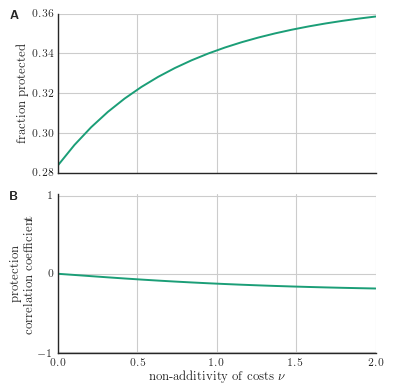

In [6]:
fig = plot_pcov(ps)
plotting.label_axes(fig, xy=(-0.15, 0.97))
fig.savefig('SIniinfection.pdf')
fig.savefig('SIniinfection.svg')

**Optimal protection strategy against two equally frequent pathogens $\pi_{\rm env, 1} = \pi_{\rm env, 2} = 0.4$ as a function of the degree of non-additivity of the cost of infection $\nu$.**
**(A)** Fraction of population protected against a particular pathogen. **(B)** Pearson correlation coefficient between the protection states against the two pathogens. As costs are non-additive, the problem no longer factorizes and the optimal strategy no longer chooses protections against different pathogens independently. However, here the optimal strategy treats each pathogen almost indendently, as measured by the low correlation coefficient. With an increasing cost of co-infection, more protection is needed, in agreement with our intuition that co-infection leads to higher effective costs. Parameters: $c_{\rm infection} = 2$, $c_{\rm defense} = c_{\rm constitutive} = 1$, optimization of the distribution over protection states respecting the probability simplex constraints using an accelerated projected gradient algorithm as described in [Mayer et.al. 2015].